## Improved Model - Kalman Residual Model

Implemented a Kalman-residual pairs trading strategy using BankNifty and Nifty spreads, dynamically estimating the hedge ratio with a Kalman filter. Generated trading signals based on the residual z-score with adaptive entry/exit thresholds and volatility scaling. Backtested the strategy over the dataset, calculating trade-wise PnL and overall performance metrics. The strategy achieved an absolute return of 3.22M, an annualized Sharpe of 6.02, a very low maximum drawdown of ~0.31%, a high win rate of 89.5%, and executed 2848 trades, demonstrating strong risk-adjusted performance.

Imported necessary libraries

In [1]:
!pip install tqdm

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (12,6)})

DATA_PATH = '/content/drive/MyDrive/Quant_project/data.parquet'


Loaded and cleaned the Nifty and BankNifty implied volatility data, filtered it for regular trading hours, converted relevant columns to numeric types, dropped any missing values, and calculated the spread between BankNifty and Nifty.

In [2]:
df = pd.read_parquet(DATA_PATH)

if not np.issubdtype(df.index.dtype, np.datetime64):
    df.index = pd.to_datetime(df.index)

df = df.sort_index()
df = df.between_time('09:15','15:30')

bn_col = 'banknifty'
nf_col = 'nifty'
tte_col = 'tte'

df[bn_col] = pd.to_numeric(df[bn_col], errors='coerce')
df[nf_col] = pd.to_numeric(df[nf_col], errors='coerce')
df[tte_col] = pd.to_numeric(df[tte_col], errors='coerce')
df = df.dropna(subset=[bn_col, nf_col, tte_col])

df['spread'] = df[bn_col] - df[nf_col]

print(f"Loaded. Rows: {len(df)}")
df.head()


Loaded. Rows: 180009


,banknifty,nifty,tte,spread
time,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588


Defined helper functions for the Kalman filter strategy:

*trade_pnl* calculates the PnL for each trade based on entry/exit spread, TTE, and trade direction.

*performance_from_trades* computes strategy metrics (absolute return, annualized Sharpe, max drawdown, drawdown %, win rate, trade count) and constructs the cumulative equity series from the trade-level PnL.

In [3]:
def trade_pnl(spread_entry, spread_exit, tte_entry, direction, multiplier=1.0):
    sign = 1 if direction=='long_spread' else -1
    pnl = (spread_exit - spread_entry) * (tte_entry**0.7) * sign * multiplier
    return pnl

def performance_from_trades(trades_df):
    if trades_df.empty or 'Pnl' not in trades_df.columns:
        return {
            'Absolute Return': 0,
            'Annualized Sharpe': np.nan,
            'Max Drawdown': np.nan,
            'Max Drawdown %': np.nan,
            'Win Rate': np.nan,
            'Trade Count': 0,
            'Equity Series': pd.Series(dtype=float)
        }

    trades_df = trades_df.copy()
    trades_df['Pnl'] = pd.to_numeric(trades_df['Pnl'], errors='coerce')
    trades_df = trades_df.dropna(subset=['Pnl'])
    if trades_df.empty:
        return {
            'Absolute Return': 0,
            'Annualized Sharpe': np.nan,
            'Max Drawdown': np.nan,
            'Max Drawdown %': np.nan,
            'Win Rate': np.nan,
            'Trade Count': 0,
            'Equity Series': pd.Series(dtype=float)
        }

    equity = trades_df['Pnl'].cumsum().rename('Equity')
    equity = equity.fillna(method='ffill').fillna(0)

    total_return = equity.iloc[-1] if len(equity) > 0 else 0
    trade_count = len(trades_df)
    win_rate = (trades_df['Pnl'] > 0).mean() * 100 if trade_count > 0 else np.nan

    trades_df['Exit_date'] = pd.to_datetime(trades_df['Exit_time']).dt.date
    daily_pnl = trades_df.groupby('Exit_date')['Pnl'].sum()
    daily_ret = daily_pnl.values
    if len(daily_ret) > 1 and np.std(daily_ret) > 0:
        ann_sharpe = (np.mean(daily_ret) / np.std(daily_ret)) * np.sqrt(252)
    else:
        ann_sharpe = np.nan

    running_max = np.maximum.accumulate(equity.values)
    drawdowns = running_max - equity.values
    max_dd = np.nanmax(drawdowns) if len(drawdowns) > 0 else np.nan
    max_dd_pct = (max_dd / running_max.max() * 100) if running_max.max() > 0 else np.nan

    return {
        'Absolute Return': float(total_return),
        'Annualized Sharpe': float(ann_sharpe),
        'Max Drawdown': float(max_dd),
        'Max Drawdown %': float(max_dd_pct),
        'Win Rate': float(win_rate),
        'Trade Count': trade_count,
        'Equity Series': equity
    }


Implemented Kalman filter to estimate a time-varying hedge ratio (beta) between two series, recursively updating beta using observation and state covariance, returning dynamic beta series.

In [4]:
def kalman_beta_series(x, y, delta=1e-5, R=0.01):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    beta = np.zeros(n)
    P = np.array([[1.0]])
    beta_t = np.array([0.0])
    Q = delta / (1 - delta) * np.eye(1)

    for t in range(n):
        H = np.array([[x[t]]])
        S = H.dot(P).dot(H.T) + R
        K = P.dot(H.T) / S
        yhat = (H.dot(beta_t))[0]
        residual = y[t] - yhat
        beta_t = beta_t + (K.flatten() * residual)
        P = (P - K.dot(H).dot(P)) + Q
        beta[t] = beta_t[0]

    return beta


Implemented Kalman-residual-based backtest for pairs trading, computing dynamic beta between BankNifty and Nifty, calculating residuals, z-scores, correlation and volatility scaling, generating trades with entry/exit rules, stop-loss, max holding, and returning trade-level PnL along with intermediate data series.

In [5]:
def backtest_kalman_residual(df,
                             kalman_delta=1e-5,
                             obs_var=0.01,
                             rm_window=120,
                             z_entry=1.0, z_exit=0.4,
                             multiplier=5000,
                             volatility_scale_window=120,
                             min_corr=0.7,
                             max_holding_minutes=5*390,
                             stop_loss_point=0.5):

    y = df[bn_col].values
    x = df[nf_col].values
    beta_series = kalman_beta_series(x, y, delta=kalman_delta, R=obs_var)

    data = df[['spread', tte_col]].copy().rename(columns={tte_col:'tte'})
    data['beta'] = beta_series
    data['resid'] = df[bn_col].values - data['beta'] * df[nf_col].values
    data['rm_resid'] = data['resid'].ewm(span=rm_window, adjust=False).mean()
    data['std_resid'] = data['resid'].ewm(span=rm_window, adjust=False).std()
    data['z_resid'] = (data['resid'] - data['rm_resid']) / data['std_resid']
    data['corr'] = df[bn_col].rolling(window=rm_window, min_periods=10).corr(df[nf_col])
    data['vol_scale'] = 1.0 / (data['std_resid'].rolling(window=volatility_scale_window, min_periods=10).mean() + 1e-8)
    data['vol_scale'] = data['vol_scale'].clip(0.1, 10.0)

    trades = []
    status = 0
    entry_index = None
    entry_time = None
    entry_s = None
    entry_tte = None
    entry_z = None
    entry_vol_scale = None
    holding_counter = 0
    indices = list(data.index)

    for i, ts in enumerate(indices):
        row = data.iloc[i]
        z = row['z_resid']; s=row['spread']; tte=row['tte']; corr=row['corr']; vol_scale=row['vol_scale']
        if pd.isna(z) or pd.isna(corr): continue

        if corr < min_corr:
            if status!=0:
                exit_time = ts; exit_s = s
                pnl = trade_pnl(entry_s, exit_s, entry_tte, direction=('long_spread' if status==2 else 'short_spread'), multiplier=entry_vol_scale*multiplier)
                trades.append({'Entry_time':entry_time,'Exit_time':exit_time,'Pnl':pnl})
                status=0; entry_index=None
            continue

        if status==0 and z > z_entry:
            status=1; entry_index=i; entry_time=ts; entry_s=s; entry_tte=tte; entry_z=z; entry_vol_scale=vol_scale; holding_counter=0
            continue

        if status==0 and z < -z_entry:
            status=2; entry_index=i; entry_time=ts; entry_s=s; entry_tte=tte; entry_z=z; entry_vol_scale=vol_scale; holding_counter=0
            continue

        if status!=0:
            holding_counter += 1
            if (status==1 and z < z_exit) or (status==2 and z > -z_exit):
                exit_time = ts; exit_s = s
                pnl = trade_pnl(entry_s, exit_s, entry_tte, direction=('short_spread' if status==1 else 'long_spread'), multiplier=entry_vol_scale*multiplier)
                trades.append({'Entry_time':entry_time,'Exit_time':exit_time,'Pnl':pnl})
                status=0; entry_index=None; continue

            adverse_move = (s - entry_s) if status==2 else (entry_s - s)
            if adverse_move < -stop_loss_point:
                exit_time = ts; exit_s = s
                pnl = trade_pnl(entry_s, exit_s, entry_tte, direction=('long_spread' if status==2 else 'short_spread'), multiplier=entry_vol_scale*multiplier)
                trades.append({'Entry_time':entry_time,'Exit_time':exit_time,'Pnl':pnl, 'Exit_reason': 'stop_loss'})
                status=0; entry_index=None; continue

            if holding_counter >= max_holding_minutes:
                exit_time = ts; exit_s = s
                pnl = trade_pnl(entry_s, exit_s, entry_tte, direction=('long_spread' if status==2 else 'short_spread'), multiplier=entry_vol_scale*multiplier)
                trades.append({'Entry_time':entry_time,'Exit_time':exit_time,'Pnl':pnl, 'Exit_reason': 'max_holding'})
                status=0; entry_index=None; continue

    trades_df = pd.DataFrame(trades)
    return trades_df, data


Implemented Kalman filter-based pairs trading strategy: calculated time-varying hedge ratio (beta) between BankNifty and Nifty, generated residual-based z-scores, applied dynamic entry/exit thresholds with volatility scaling, enforced correlation and stop-loss rules, executed backtest, and computed performance metrics.

In [6]:
params = dict(
    kalman_delta = 1e-5,
    obs_var = 0.01,
    rm_window = 120,
    z_entry = 1.0,
    z_exit = 0.4,
    multiplier = 5000,
    volatility_scale_window = 120,
    min_corr = 0.75,
    max_holding_minutes = 5*390,
    stop_loss_point = 1.0
)

trades_kalman, kalman_data = backtest_kalman_residual(df,
                                                     kalman_delta=params['kalman_delta'],
                                                     obs_var=params['obs_var'],
                                                     rm_window=params['rm_window'],
                                                     z_entry=params['z_entry'],
                                                     z_exit=params['z_exit'],
                                                     multiplier=params['multiplier'],
                                                     volatility_scale_window=params['volatility_scale_window'],
                                                     min_corr=params['min_corr'],
                                                     max_holding_minutes=params['max_holding_minutes'],
                                                     stop_loss_point=params['stop_loss_point'])

metrics_kalman = performance_from_trades(trades_kalman)
print("Kalman-residual metrics:")
for k,v in metrics_kalman.items():
    if k!='Equity Series': print(k, v)


Kalman-residual metrics:
Absolute Return 3226235.0771087925
Annualized Sharpe 6.016379875588122
Max Drawdown 9964.527762083919
Max Drawdown % 0.3088473618275271
Win Rate 89.46629213483146
Trade Count 2848


Plotted cumulative PnL of the Kalman-residual strategy

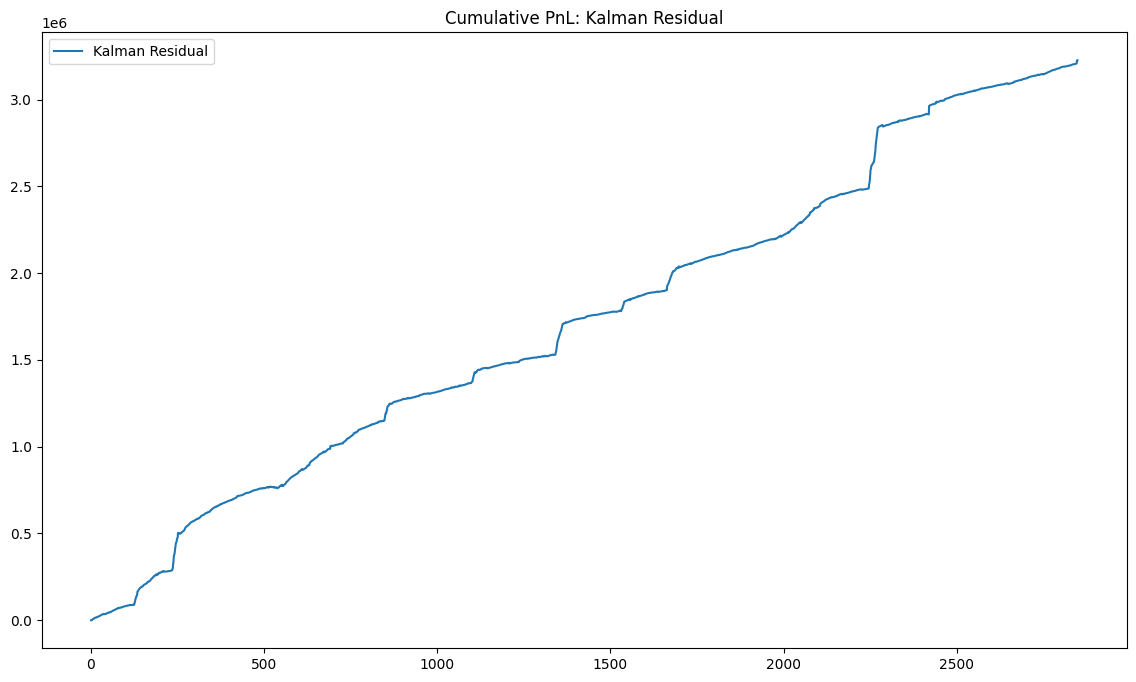

In [10]:
plt.figure(figsize=(14,8))
if not metrics_kalman['Equity Series'].empty:
    metrics_kalman['Equity Series'].rename("Kalman Residual").plot()
plt.title("Cumulative PnL: Kalman Residual")
plt.legend()
plt.show()
